In [140]:
import numpy as np
import pandas as pd
import os
from glob import glob
import matplotlib.pylab as plt
from tqdm import tqdm
from sklearn.cluster import KMeans
from Preprocessing2 import Signal_process, Stat_process 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from icecream import ic 
from scipy import signal
import pickle
%matplotlib inline

# Data Load

In [2]:
path = 'D:/Data/CMAPSSData'

train_path_list = sorted(glob(path + '/train*'))
test_path_list = sorted(glob(path + '/test*'))
rul_path_list = sorted(glob(path + '/RUL*'))

In [3]:
col_name = ['unit number', 'time', 'op1', 'op2', 'op3']
temp = ['sensor %d'%(i+1) for i in range(23)]

load_col_name = col_name + temp
col_name = load_col_name[:-2]

In [158]:
train = []
for t_path in train_path_list:
    temp = pd.read_table(t_path, sep = ' ', header = None, names=load_col_name)
    train.append(temp[col_name])

test = []
for t_path in test_path_list:
    temp = pd.read_table(t_path, sep = ' ', header = None, names=load_col_name)
    test.append(temp[col_name])
    
RUL = []
for r_path in rul_path_list:
    temp = pd.read_table(r_path, header = None, names = ['RUL'])
    RUL.append(temp)

# Seperate unit number, time and sensor datas

In [159]:
train_index = []
for key, value in enumerate(train):
    train_index.append(train[key][['unit number', 'time']])
    train[key] = train[key].drop(['unit number', 'time'], axis = 1)

# Normalize(optional)

In [160]:
#SCALE = 'None' # MINMAX, STANDARD

def NORM(TRAIN, SCALE):
    if SCALE == 'MINMAX':
        scaler_norm = []
        for key, values in enumerate(TRAIN):
            scaler_norm_ = MinMaxScaler().fit(values)
            scaler_norm.append(scaler_norm_)
            TRAIN[key] = scaler_norm_.transform(values)
            TRAIN[key] = pd.DataFrame(TRAIN[key], columns = col_name[2:])

    if SCALE == 'STANDARD':
        scaler_norm = []
        for key, values in enumerate(TRAIN):
            scaler_norm_ = StandardScaler().fit(values)
            scaler_norm.append(scaler_norm_)
            TRAIN[key] = scaler_norm_.transform(values)
            TRAIN[key] = pd.DataFrame(TRAIN[key], columns = col_name[2:])
    
    return TRAIN

In [161]:
stat = Stat_process()
select = [stat.RMS, stat.Crest, stat.Shape, stat.p2p, stat.Impulse, stat.Margin, stat.waveform_Entropy, stat.get_median_absolute_deviation, stat.skew, stat.kurt]

statistic_name = 'stat.RMS, stat.Crest, stat.Shape, stat.p2p, stat.Impulse, stat.Margin, stat.waveform_Entropy, stat.get_median_absolute_deviation, stat.skew, stat.kurt'
statistic_name = statistic_name.replace(" ","")
statistic_name = statistic_name.replace('stat.',"")
statistic_name = statistic_name.split(',')

# Variance Check Visualization

In [162]:
''' non normalize'''
def Variance_check_visu(train_, col_name, thres):
    #train_ = pd.concat([train_index[0], train[0]], axis = 1)

    variance_check = train_.groupby('unit number').std()

    N = len(col_name)
    fig, ax = plt.subplots(21,1, figsize = (24, 48), sharey=True)
    for key, name in enumerate(col_name[5:]):
        #fig, ax = plt.subplots(1,1, figsize = (24, 1), sharey=True)
        ax[key].plot(variance_check[name], '-ok')
        ax[key].set_title(f'{name}')
        ax[key].axhline(thres, color = 'r', linewidth = 2)
    plt.show()

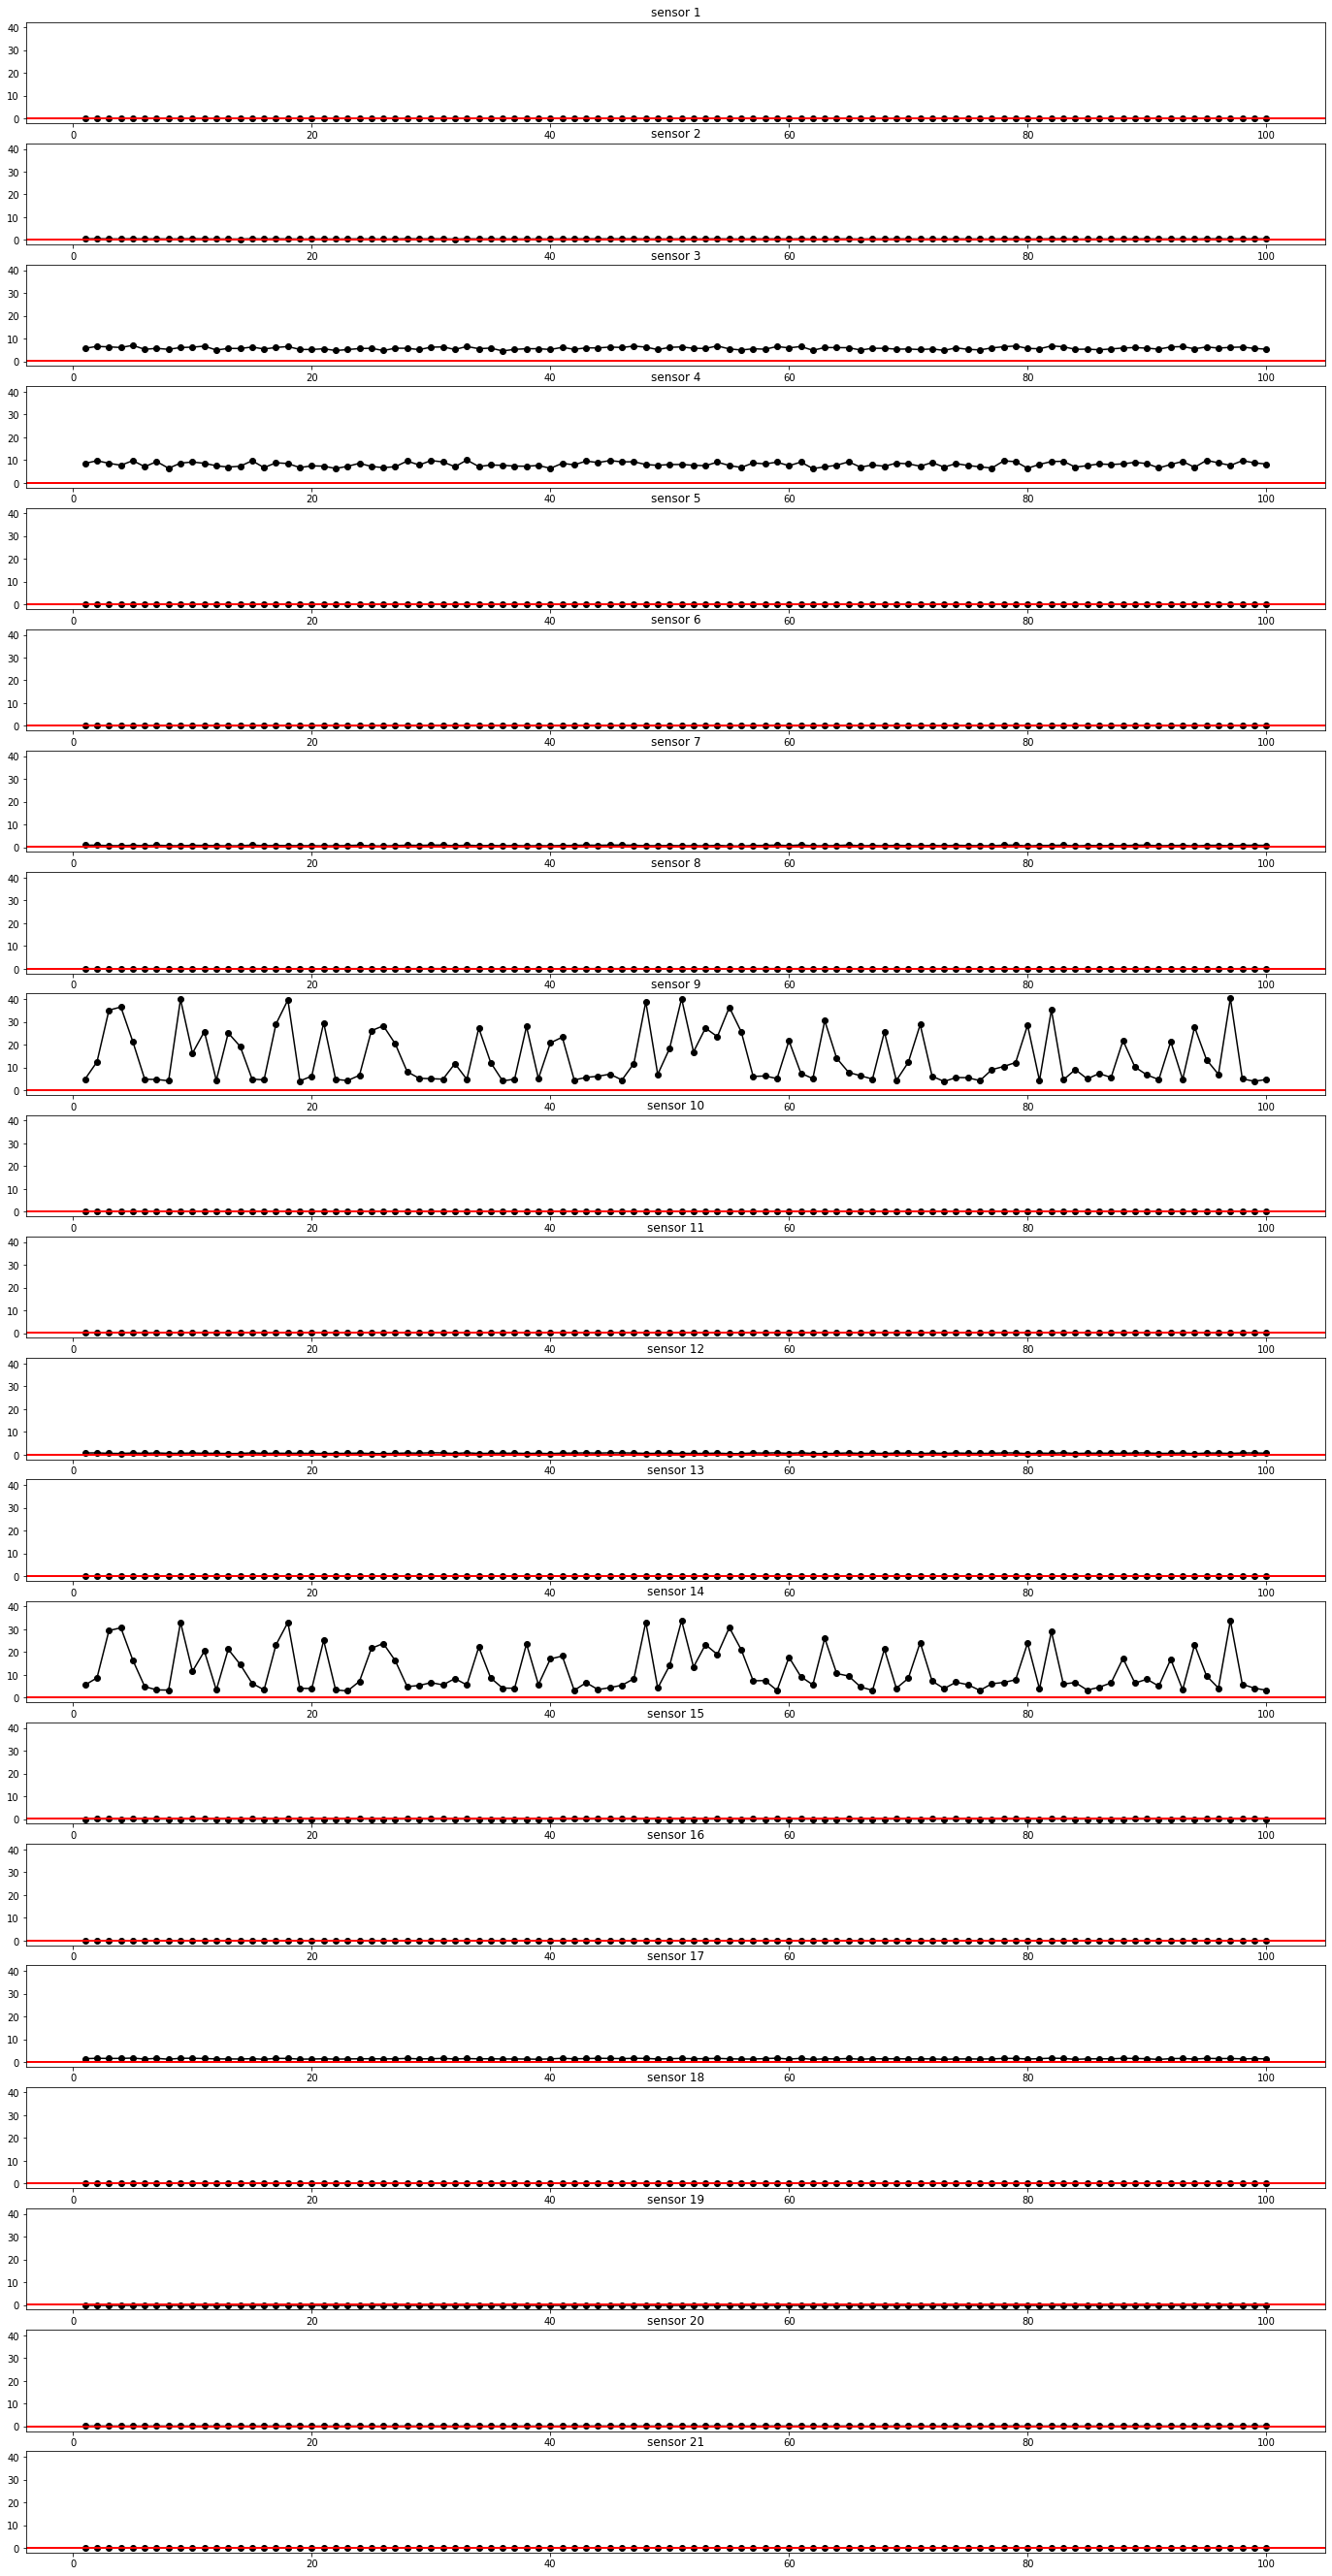

In [50]:
Variance_check_visu(pd.concat([train_index[0], train[0]], axis = 1), col_name, thres= 0.1)

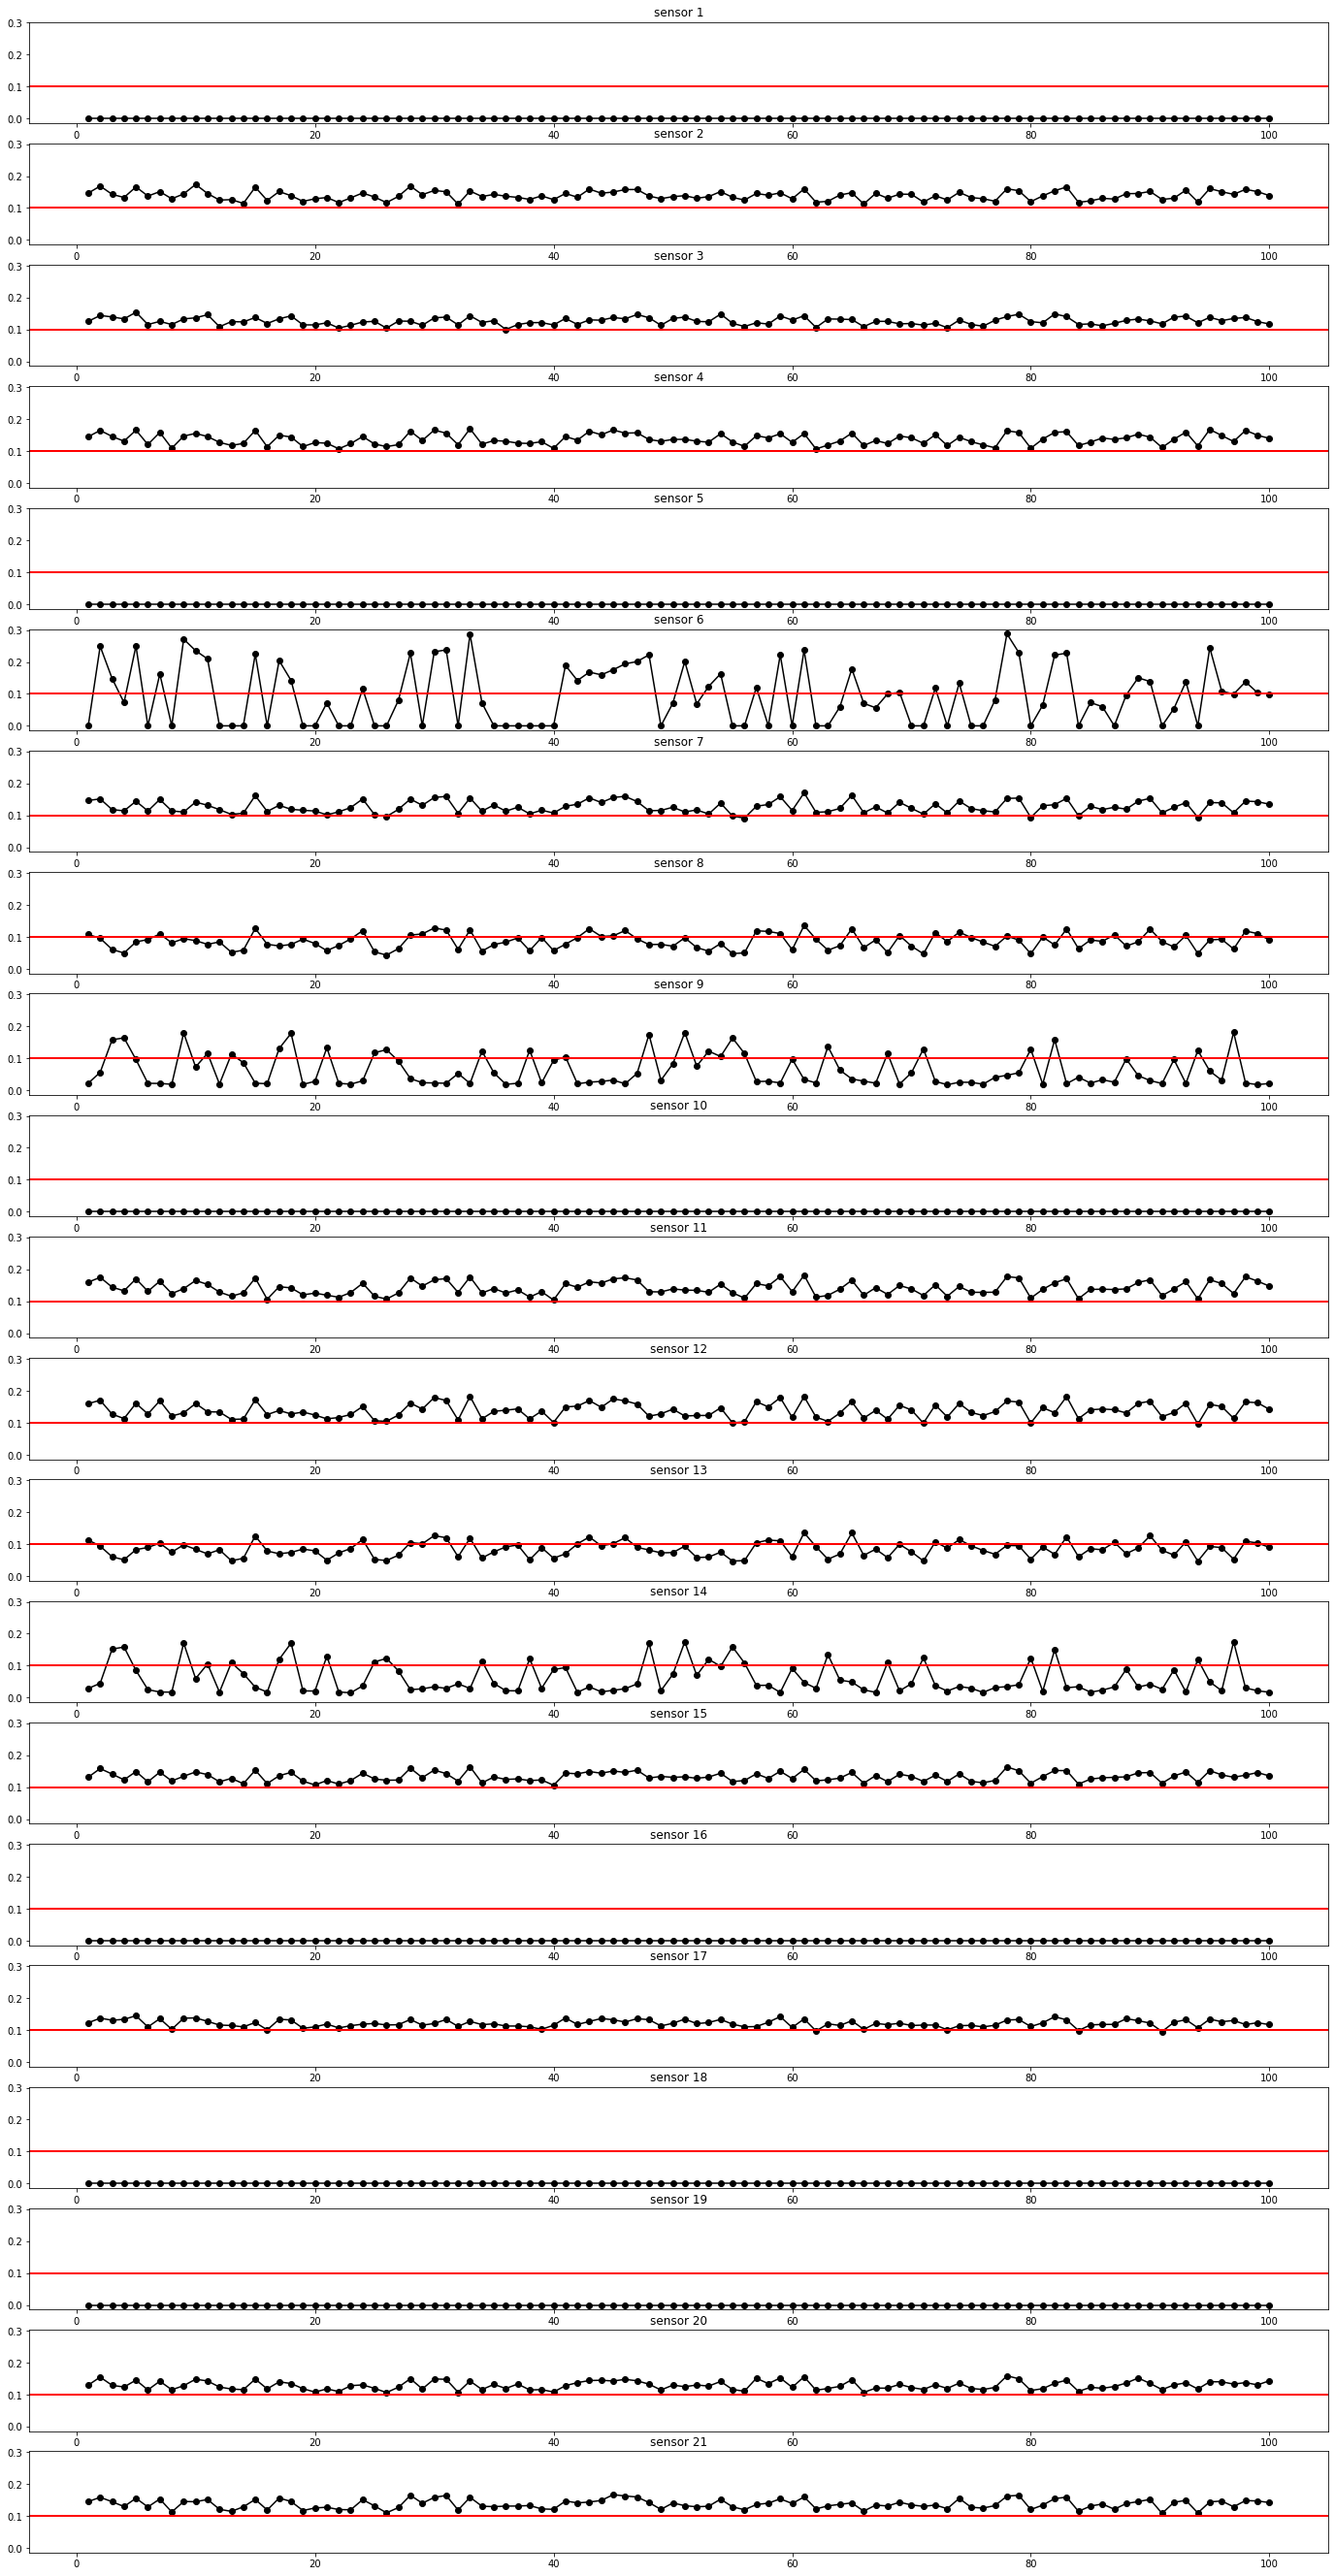

In [163]:
'''minmax norm'''
minmax_train = NORM(train.copy(), 'MINMAX')
Variance_check_visu(pd.concat([train_index[0], minmax_train[0]], axis = 1), col_name, thres=0.1)

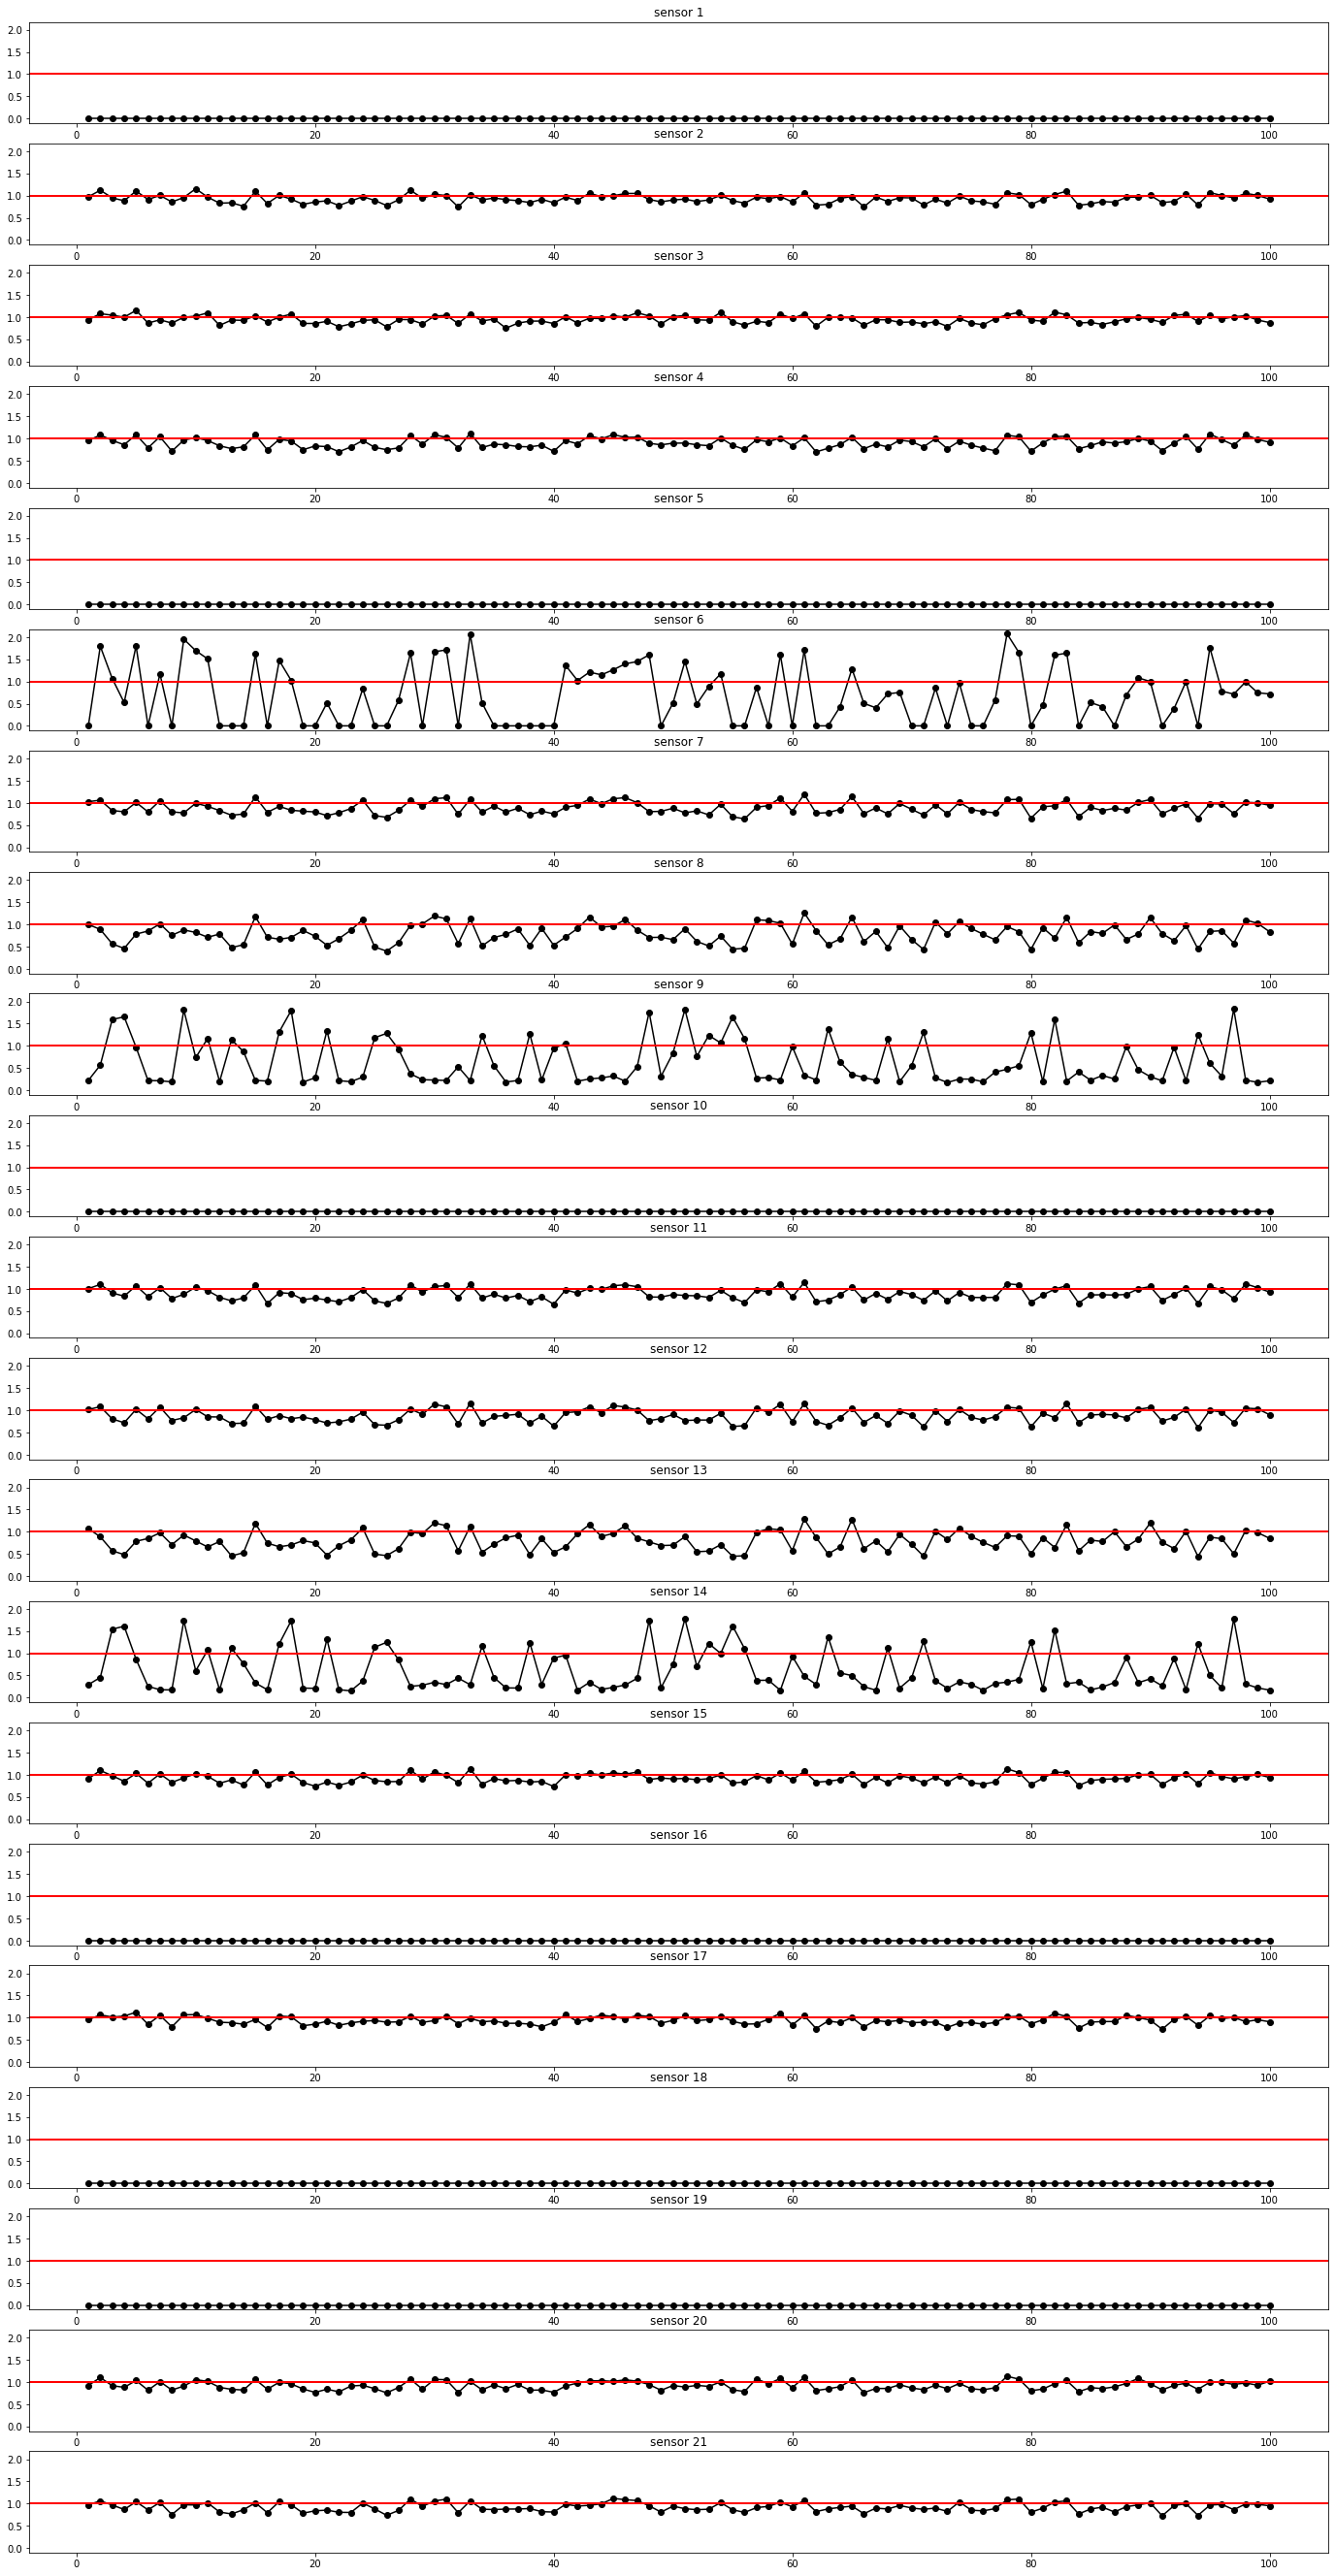

In [55]:
'''standard norm'''
standard_train = NORM(train.copy(), 'STANDARD')
Variance_check_visu(pd.concat([train_index[0], standard_train[0]], axis = 1), col_name, thres=1)

In [164]:
train_ = pd.concat([train_index[0], train[0]], axis = 1)

variance_check = train_.groupby('unit number').std()
bol = variance_check > 0.1
selected_idx = np.where(bol.sum(axis=0) == 100)[0] + 1
selected_col = [col_name[index] for index in selected_idx]
ic(selected_col)


train_ = pd.concat([train_index[0], minmax_train[0]], axis = 1)
variance_check = train_.groupby('unit number').std()
bol = variance_check > 0.1
selected_idx = np.where(bol.sum(axis=0) == 100)[0] + 1
selected_col = [col_name[index] for index in selected_idx]
ic(selected_col)


train_ = pd.concat([train_index[0], standard_train[0]], axis = 1)
variance_check = train_.groupby('unit number').std()
bol = variance_check > 0.1
selected_idx = np.where(bol.sum(axis=0) == 100)[0] + 1
selected_col = [col_name[index] for index in selected_idx]
ic(selected_col)
print('\n')

ic| selected_col: ['time',
                   'sensor 2',
                   'sensor 3',
                   'sensor 4',
                   'sensor 7',
                   'sensor 9',
                   'sensor 11',
                   'sensor 12',
                   'sensor 14',
                   'sensor 17',
                   'sensor 20']
ic| selected_col: ['time',
                   'op1',
                   'op2',
                   'sensor 2',
                   'sensor 3',
                   'sensor 4',
                   'sensor 11',
                   'sensor 15',
                   'sensor 20',
                   'sensor 21']
ic| selected_col: ['time',
                   'op1',
                   'op2',
                   'sensor 2',
                   'sensor 3',
                   'sensor 4',
                   'sensor 7',
                   'sensor 8',
                   'sensor 9',
                   'sensor 11',
                   'sensor 12',
                   'sensor 13

# Statistic feature extraction

In [165]:
target_length = 500

new_train = []
train_len = []
for D in train_index:
    temp = D.groupby('unit number').max()
    train_len.append(len(temp))
    new_train.append(np.zeros(shape = [len(temp), target_length, len(selected_col[1:])]))
new_train[0].shape

(100, 500, 16)

In [166]:
for key, values in enumerate(train_index):
    for i in range(train_len[key]):
        unit_index = values.groupby('unit number').get_group(i+1).index

        new_train[key][i] = signal.resample(minmax_train[key][selected_col[1:]].loc[unit_index], target_length)

In [167]:
'''
numpy shape:
(# of data, window_size, statistic, sensor)
'''
window_size = 10
statistic = []
for key, values in enumerate(new_train):
    statistic_temp = []
    for i in tqdm(range(train_len[key])):
        temp = []
        for j in range(int(500/window_size)):
            tem = stat.Concat(new_train[key][i][window_size*j:window_size*(j+1)], select = select).reshape(1,1, len(statistic_name), len(selected_col[1:]))
            temp.append(tem)
        temp = np.concatenate(temp, axis = 1)
        statistic_temp.append(temp)
    statistic_temp = np.concatenate(statistic_temp)
    statistic.append(statistic_temp)
statistic[0].shape

100%|████████████████████████████████████████████████████████████████████████████████| 249/249 [00:06<00:00, 37.46it/s]


(100, 50, 10, 16)

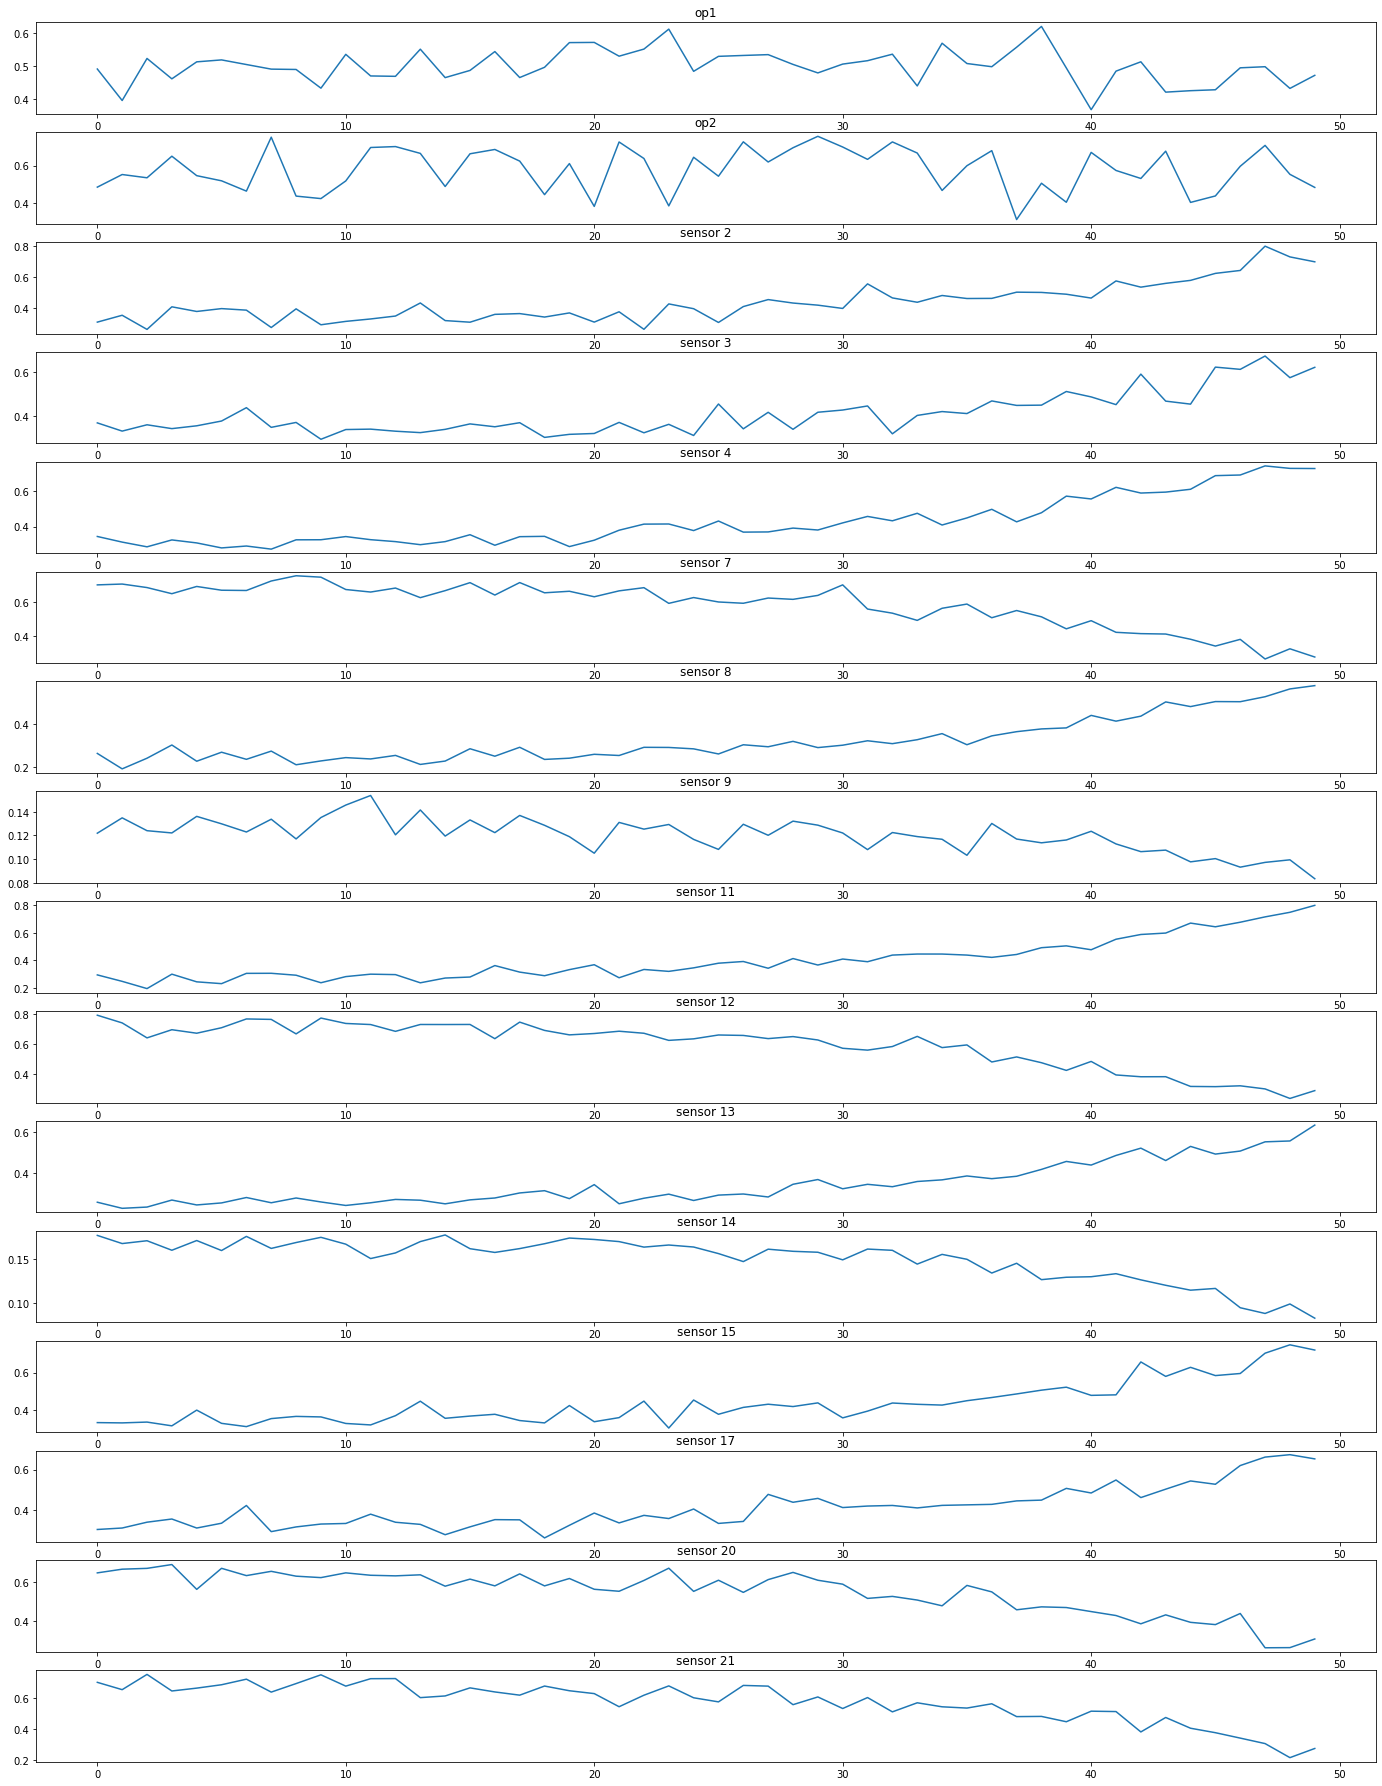

In [168]:
N = statistic[0].shape[-1]
fig, ax = plt.subplots(N,1, figsize=(24,32))
for key, name in enumerate(selected_col[1:]):
    ax[key].plot(statistic[0][0,:,0,key])
    ax[key].set_title(f"{name}")
plt.plot()
plt.show()

In [179]:
for D in new_train:
    print(D.shape[0])

100
260
100
249


In [177]:
for D in new_train:
    N = D.shape[0]
    y = np.array(list(np.linspace(0,1,50))*D)
    y = y.reshape(100,50)

In [171]:
with open("statistic_minamx.pickle", 'wb') as f:
    pickle.dump(statistic, f, pickle.HIGHEST_PROTOCOL)
# with open("file.txt", 'r') as f:
#     score = [line.rstrip('\n') for line in f]


In [190]:
new_train[0].shape

(100, 500, 16)

In [175]:
with open("signal_minmax.pickle", 'wb') as f:
    pickle.dump(new_train, f, pickle.HIGHEST_PROTOCOL)

TypeError: expected str, bytes or os.PathLike object, not numpy.ndarray